In [1]:
import sys
import torch
from torch.utils.data import Subset
import torchvision.models as tvmodels
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

sys.path.insert(0, "../src")
import exlib
from exlib.modules import *
from exlib.datasets.abdomen_organs import *

In [2]:
DATA_DIR = "/home/antonxue/foo/data/abdomen_exlib/"
train_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="train")
test_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="test")

In [3]:
model = AbodmenModel(in_channels=3, out_channels=3)
model.eval();

In [8]:
x, olabel, glabel = train_dataset[2]
y = model(x[None,...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

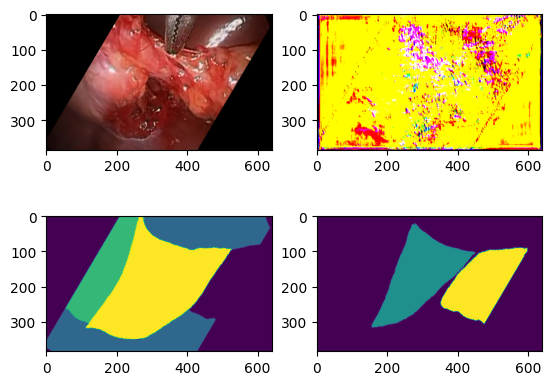

In [20]:
plt.figure()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x.numpy().transpose(1,2,0))
ax[0,1].imshow(40 * y[0].detach().numpy().transpose(1,2,0))
ax[1,0].imshow(30 * olabel.numpy().transpose(1,2,0))
ax[1,1].imshow(40 * glabel.numpy().transpose(1,2,0))

In [22]:
x, olabel, glabel = test_dataset[2]
y = model(x[None,...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

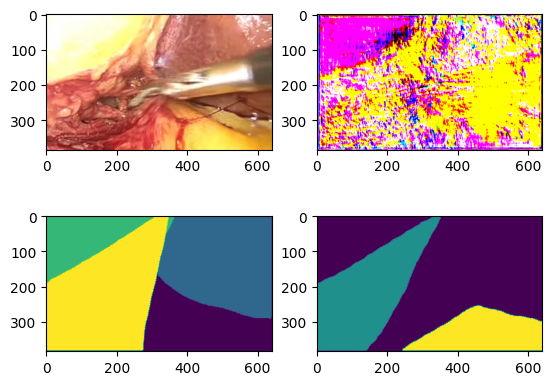

In [23]:
plt.figure()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x.numpy().transpose(1,2,0))
ax[0,1].imshow(40 * y[0].detach().numpy().transpose(1,2,0))
ax[1,0].imshow(30 * olabel.numpy().transpose(1,2,0))
ax[1,1].imshow(40 * glabel.numpy().transpose(1,2,0))